In [423]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle
from time import process_time
import math


# Reading Data from File
Reading data from train_set_features.pkl. There are about 2000 train data and 600 test data
each data is a picture of a fruit taken from different angles.

In [ ]:
# loading training set features
f = open("Datasets/train_set_features.pkl", "rb")
train_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=train_set_features2, axis=0)
train_set_features = train_set_features2[:, features_STDs > 52.3]

# changing the range of data between 0 and 1
train_set_features = np.divide(train_set_features, train_set_features.max())

# loading training set labels
f = open("Datasets/train_set_labels.pkl", "rb")
train_set_labels = pickle.load(f)
f.close()

# ------------
# loading test set features
f = open("Datasets/test_set_features.pkl", "rb")
test_set_features2 = pickle.load(f)
f.close()

# reducing feature vector length
features_STDs = np.std(a=test_set_features2, axis=0)
test_set_features = test_set_features2[:, features_STDs > 48]

# changing the range of data between 0 and 1
test_set_features = np.divide(test_set_features, test_set_features.max())

# loading test set labels
f = open("Datasets/test_set_labels.pkl", "rb")
test_set_labels = pickle.load(f)
f.close()

# ------------
# preparing our training and test sets - joining datasets and lables
train_set = []
test_set = []

for i in range(len(train_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(train_set_labels[i])] = 1
    label = label.reshape(4, 1)
    train_set.append((train_set_features[i].reshape(102, 1), label))

for i in range(len(test_set_features)):
    label = np.array([0, 0, 0, 0])
    label[int(test_set_labels[i])] = 1
    label = label.reshape(4, 1)
    test_set.append((test_set_features[i].reshape(102, 1), label))

# shuffle
random.shuffle(train_set)
random.shuffle(test_set)

# print size
print(len(train_set))  # 1962
print(len(test_set))  # 662

# Useful functions
down below some functions have been defined that maybe useful for training our model.
for example defining activation function and its derivative functions to calculate z
 and output for each layer and calculating the final result and accuracy

In [357]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

def derivative_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def calculate_z(input, w, b):
    z = np.add(w.dot(input), b)
    return z

def calculate_z_layers(inputs, weights, biases):
    current_input = [inputs]
    z_layers = []
    for (w, b) in zip(weights, biases):
        z_layers.append(calculate_z(current_input[-1], w, b))
        current_input.append(sigmoid(calculate_z(current_input[-1], w, b)))
    return z_layers


def calculate_output(inputs, weights, biases):
    output = []
    for input in inputs:
        current_input = input
        for (w, b) in zip(weights, biases):
            current_input = sigmoid(calculate_z(current_input, w, b))
        output.append(current_input)
    return output


def calculate_layer_values(inputs, weights, biases):
    current = [inputs]
    for (w, b) in zip(weights, biases):
        current.append(sigmoid(calculate_z(current[-1], w, b)))

    return current


def calculate_accuracy(output, labels):
    num_correct = 0
    for i in range(len(output)):
        index_max = np.argmax(output[i])
        if index_max == labels[i]:
            num_correct += 1

    return num_correct/len(output)


# Initialize weights
Here is a function to initialize weights with random and initialize biases with
array of zeros

In [ ]:
def initialize_weights():
    #initializing weights
    W1 = np.random.normal(0, 0.5, size=(150, 102))
    W2 = np.random.normal(0, 0.5, size=(60, 150))
    W3 = np.random.normal(0, 0.5, size=(4, 60))

    #initializing biases
    b1 = np.zeros(150)
    b2 = np.zeros(60)
    b3 = np.zeros(4)

    weights = [W1, W2, W3]
    biases = [b1, b2, b3]

    return weights, biases


# FeedForward
Here we test our neural network model since the weights are random
numbers and the model has not been trained the accuracy in this case
will be close to 25%

In [254]:
sample_train, sample_train_label = zip(*random.sample(list(zip(train_set_features, train_set_labels)), 200))
weights, biases = initialize_weights()
sample_train = np.asarray(sample_train)
sample_train_label = np.asarray(sample_train_label)
output = np.asarray(calculate_output(sample_train, weights, biases))
print("Accuracy: ", end='')
print(calculate_accuracy(output, sample_train_label))


Accuracy: 0.3


# Training
I train the model here with backpropagation using two methods iterative learning with "for"
and vectorized learning with matrix. The training in both methods uses gradient decent with sigmoid
activation function.

## Iterative training
Here we use iterative learning to train our model given learning rate, batch size, number of epochs
a training set and labels assigned to the training set.

In [436]:
def iterative_learning(num_epochs,batch_size, learning_rate, weights, biases, samples, labels):
    cost_epochs = []
    batches = []
    batch_labels = []

    train_set = zip(samples, labels)

    for n in range(num_epochs):

        train_set = [(x, y) for (x, y) in zip(samples, labels)]
        random.shuffle(train_set)
        for i in range(0, int(len(samples)/batch_size)):
            batches.append(train_set[i*batch_size: (i+1)*batch_size])

        num_batch = 0
        for batch in batches:
            grad_W1 = np.zeros((150, len(samples[0])))
            grad_W2 = np.zeros((60, 150))
            grad_W3 = np.zeros((4, 60))
            grad_W = [grad_W1, grad_W2, grad_W3]

            grad_b1 = np.zeros(150)
            grad_b2 = np.zeros(60)
            grad_b3 = np.zeros(4)
            grad_b = [grad_b1, grad_b2, grad_b3]

            for i in range(batch_size):
                data = batch[i][0]
                label_res = batch[i][1]
                data_label = []
                for j in range(4):
                    if label_res == j:
                        data_label.append(1.0)
                    else:
                        data_label.append(.0)

                layers_output = calculate_layer_values(np.array(data), weights, biases)
                z_layers = calculate_z_layers(np.array(data), weights, biases)

                #Layer 3
                for j in range(np.shape(weights[2])[0]):
                    grad = 2 * (layers_output[3][j] - data_label[j]) * derivative_sigmoid(z_layers[2][j])
                    grad_b[2][j] += grad

                    for k in range(np.shape(weights[2])[1]):
                        grad_W[2][j][k] += grad * layers_output[2][k]


                grad_a2 = np.zeros(60)
                #Layer 2
                for j in range(60):
                    for k in range(4):
                        grad_a2[j] += 2 * (layers_output[3][k]-data_label[k]) * derivative_sigmoid(z_layers[2][k]) * weights[2][k][j]


                for j in range(np.shape(weights[1])[0]):
                    grad = 2 * grad_a2[j] * derivative_sigmoid(z_layers[1][j])
                    grad_b[1][j] += grad

                    for k in range(np.shape(weights[1])[1]):
                        grad_W[1][j][k] += grad * layers_output[1][k]


                grad_a1 = np.zeros(150)
                #Layer 1
                for j in range(150):
                    for k in range(60):
                        grad_a1[j] += grad_a2[k] * derivative_sigmoid(z_layers[1][k]) * weights[1][k][j]


                for j in range(np.shape(weights[0])[0]):
                    grad = grad_a1[j] * derivative_sigmoid(z_layers[0][j])
                    grad_b[0][j] += grad

                    for k in range(np.shape(weights[0])[1]):
                        grad_W[0][j][k] += grad * layers_output[0][k]

            for j in range(3):
                weights[j] -= learning_rate * grad_W[j]/batch_size
                biases[j] -= learning_rate * grad_b[j]/batch_size
            num_batch += 1

        cost = 0
        for train_data in train_set:
            a0 = train_data[0]
            a1 = sigmoid(weights[0] @ a0 + biases[0])
            a2 = sigmoid(weights[1] @ a1 + biases[1])
            a3 = sigmoid(weights[2] @ a2 + biases[2])

            data_label = np.zeros(4)
            for j in range(4):
                if train_data[1] == j:
                    data_label[j] = 1.0
                else:
                    data_label[j] = .0

            for j in range(4):
                cost += np.power((a3[j] - data_label[j]), 2)

        cost /= len(samples)
        cost_epochs.append(cost)


    return cost_epochs, weights, biases



### Result
the result of the iterative learning. the accuracy is high since the images in each classes are
really close to each other but images in different classes are really different.

In [437]:
t_start = process_time()
cost_epochs, weights, biases = iterative_learning(5, 10, 1, weights, biases, sample_train, sample_train_label)
output = np.asarray(calculate_output(sample_train, weights, biases))
print("Accuracy: ", end='')
print(calculate_accuracy(output, sample_train_label))
t_stop = process_time()
print("Time:", t_stop-t_start)

Accuracy: 1.0
Time: 320.28125


#### Epochs Cost Graph
the graph of epochs cost

[7.938212584315097e-06, 7.934217982268873e-06, 7.928236861484347e-06, 7.920285970086453e-06, 7.910384258767604e-06]


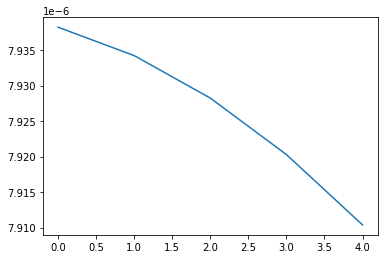

In [438]:
#cost_epochs = np.array(cost_epochs)
print(cost_epochs)
plt.plot(cost_epochs)
plt.show()

## Vectorized Training
Here the model has been trained using Vectorized form and instead of using "for" to calculate
the gradient of the cost we use matrix multiplication so it is much faster than iterative training

In [424]:
def vectorized_learning(num_epochs,batch_size, learning_rate, weights, biases, samples, labels):
    #cost_epochs = [[0]*4]*num_epochs
    cost_epochs = []
    batches = []
    batch_labels = []

    train_set = zip(samples, labels)
    total_cost = []

    for n in range(num_epochs):

        train_set = [(x, y) for (x, y) in zip(samples, labels)]
        random.shuffle(train_set)

        for i in range(0, int(len(samples)/batch_size)):
            batches.append(train_set[i*batch_size: (i+1)*batch_size])

        num_batch = 0
        for batch in batches:
            grad_W1 = np.zeros((150, len(samples[0])))
            grad_W2 = np.zeros((60, 150))
            grad_W3 = np.zeros((4, 60))
            grad_W = [grad_W1, grad_W2, grad_W3]

            grad_b1 = np.zeros(150)
            grad_b2 = np.zeros(60)
            grad_b3 = np.zeros(4)
            grad_b = [grad_b1, grad_b2, grad_b3]

            for i in range(batch_size):
                data = batch[i][0]
                label_res = batch[i][1]
                data_label = []
                for j in range(4):
                    if label_res == j:
                        data_label.append(1.0)
                    else:
                        data_label.append(.0)

                layers_output = calculate_layer_values(np.array(data), weights, biases)
                z_layers = calculate_z_layers(np.array(data), weights, biases)

                cost = [0.0]*10
                #print("*********")
                #print(data_label)
                #print(layers_output[3])


                #Layer 3
                grad_b[2] += 2 * (layers_output[3] - data_label) * derivative_sigmoid(z_layers[2])
                grad_W[2] += np.transpose(np.transpose([layers_output[2]]) @ np.array([2 * (layers_output[3]-data_label) * derivative_sigmoid(z_layers[2])]))

                #Layer 2
                grad_a2 = np.transpose(weights[2]) @ (2 * derivative_sigmoid(z_layers[2]) * (layers_output[3]-data_label))
                grad_b[1] += 2 * grad_a2 * derivative_sigmoid(z_layers[1])
                grad_W[1] +=np.transpose(np.transpose([layers_output[1]]) @ np.array([grad_a2 * derivative_sigmoid(z_layers[1])]))

                #Layer 1
                grad_a1 = np.transpose(weights[1]) @ (derivative_sigmoid(z_layers[1]) * grad_a2)
                grad_b[0] += grad_a1 * derivative_sigmoid(z_layers[0])
                grad_W[0] += np.transpose(np.transpose([layers_output[0]]) @ np.array([grad_a1 * derivative_sigmoid(z_layers[0])]))

            for j in range(3):
                weights[j] -= learning_rate * (grad_W[j]/batch_size)
                biases[j] -= learning_rate * (grad_b[j]/batch_size)
            num_batch += 1

        cost = 0
        for train_data in train_set:
            a0 = train_data[0]
            a1 = sigmoid(weights[0] @ a0 + biases[0])
            a2 = sigmoid(weights[1] @ a1 + biases[1])
            a3 = sigmoid(weights[2] @ a2 + biases[2])

            data_label = np.zeros(4)
            for j in range(4):
                if train_data[1] == j:
                    data_label[j] = 1.0
                else:
                    data_label[j] = .0

            for j in range(4):
                cost += np.power((a3[j] - data_label[j]), 2)

        cost /= len(samples)
        cost_epochs.append(cost)

    return cost_epochs, weights, biases


### Min Epochs
the result of the vectorized learning. the accuracy is high since the images in each classes are
really close to each other but images in different classes are really different.

In [429]:
cost_final = []
time = []
accuracy = []
for i in range(10):
    t_start = process_time()
    cost_epochs, weights, biases = vectorized_learning(5, 10, 1, weights, biases, sample_train, sample_train_label)
    output = np.asarray(calculate_output(sample_train, weights, biases))
    cost_epochs.append(cost_epochs)
    accuracy.append(calculate_accuracy(output, sample_train_label))
    t_stop = process_time()
    time.append(t_stop-t_start)

print("Accuracy:", sum(accuracy)/len(accuracy))
print("Process time:", sum(time)/len(time))

Accuracy: 1.0
Process time: 4.053125


### Min Epochs Graph

[1.18659200e-05 1.18583456e-05 1.18470111e-05 1.18319487e-05
 1.18132000e-05]


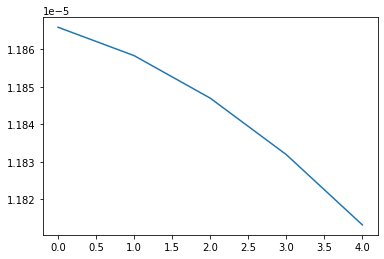

In [418]:
cost_epochs = np.array(cost_epochs)
print(cost_epochs)
plt.plot(cost_epochs)
plt.show()

# Test
using all 2000 train data with epochs = 10 and learning rate = 1 and batch size = 10.

using Test data to measure the final accuracy of the model

In [ ]:
cost_epochs, weights, biases = vectorized_learning(10, 10, 1, weights, biases, train_set_features, train_set_labels)


output = calculate_output(test_set_features, weights, biases)
print("Accuracy: ", calculate_accuracy(output, test_set_labels))
cost_epochs = np.array(cost_epochs)
plt.plot(cost_epochs)
plt.show()